In [1]:
import os
import numpy as np
import h5py
from qiskit import QuantumCircuit, QuantumRegister, Aer, IBMQ
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
import qiskit.quantum_info as qi

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
backend = provider.get_backend('ibm_kawasaki')

## First, write the results in an HDF5 file

In [3]:
results_file_name = 'compare_rzx_results_sep13.h5'

if not os.path.exists(results_file_name):
    initial_map = {'0': 'Zp', '1': 'Zm', '+': 'Xp', 'i': 'Yp'}
    
    try:
        with h5py.File(results_file_name, 'w') as out:
            for exp in ['cx', 'pe', 'li']:
                group = out.create_group(exp)
                
                if exp == 'cx':
                    # For whatever reason we got memoryslots 2 and 3
                    counts_keys = [hex(i * 4) for i in range(4)]
                else:
                    counts_keys = [hex(i) for i in range(4)]

                with open('job_ids_{}.txt'.format(exp)) as source:
                    for line in source:
                        words = line.split()
                        initial = words[0].split('_')[1]

                        job = backend.retrieve_job(words[1])
                        results = job.result().results
                        num_data_points = len(results) // 9

                        results_start = 0
                        for control_axis in ['x', 'y', 'z']:
                            for target_axis in ['x', 'y', 'z']:
                                circuit_name = '(("{}", "{}"), ("{}", "{}"))'.format(
                                    initial_map[initial[0]],
                                    initial_map[initial[1]],
                                    control_axis.upper(),
                                    target_axis.upper()
                                )
                                dataset = group.create_dataset(circuit_name, (num_data_points, 4), dtype='i')

                                for ip, result in enumerate(results[results_start:results_start + num_data_points]):
                                    counts = result.data.counts
                                    dataset[ip] = np.array([counts.get(key, 0) for key in counts_keys])
                                    
                                results_start += num_data_points
                
    except:
        try:
            os.unlink(results_file_name)
        except:
            pass
        raise

## Measure the process fidelities

For each phi point of each experiment,
- Instantiate a ProcessTomographyFitter
- Fill the input data by hand (jobs were prepared manually, not following Qiskit's naming conventions etc.)
- Run the fit and feed the result into qi.process_fidelity
  - Target unitary from QuantumCircuit

In [4]:
# Fidelity data
phi_values = np.linspace(0., np.pi / 2., 40)
process_fidelities = {'test': np.empty_like(phi_values)}

# Dummy circuit and result
for iphi, phi_value in enumerate(phi_values):
    qreg = QuantumRegister(2)
    dummy_circuit = QuantumCircuit(qreg)
    dummy_circuit.cx(0, 1)
    dummy_circuit.rz(phi_value, 1)
    dummy_circuit.cx(0, 1)
    dummy_circuits = process_tomography_circuits(dummy_circuit, qreg)
    simulator = Aer.get_backend('qasm_simulator')
    dummy_result = simulator.run(dummy_circuits, shots=1024).result()
    fitter = ProcessTomographyFitter(dummy_result, dummy_circuits)
    
    channel = fitter.fit()
        
    # Target circuit
    target_circuit = QuantumCircuit(2)
    target_circuit.rzz(phi_value, 0, 1)
    target = qi.Operator(target_circuit)

    fidelity = qi.process_fidelity(channel, target=target)
    process_fidelities['test'][iphi] = fidelity

source = h5py.File(results_file_name, 'r')

for exp in ['cx', 'pe', 'li']:
    process_fidelities[exp] = np.empty_like(phi_values)
    group = source[exp]
    
    for iphi, phi_value in enumerate(phi_values):
        # The fitter
        fitter = ProcessTomographyFitter(dummy_result, dummy_circuits)

        # Fill the input data
        for str_key in source[exp].keys():
            dataset = group[str_key]
            data = dataset[iphi]
            
            key = eval(str_key)
            value = dict()
            for ic in range(4):
                if data[ic] != 0:
                    value['{:02b}'.format(ic)] = data[ic]
                    
            fitter._data[key] = value
            
        channel = fitter.fit()
        
        # Target circuit
        target_circuit = QuantumCircuit(2)
        target_circuit.rzz(phi_value, 0, 1)
        target = qi.Operator(target_circuit)
        
        fidelity = qi.process_fidelity(channel, target=target)
        process_fidelities[exp][iphi] = fidelity

/usr/local/lib/python3.8/dist-packages/qiskit/ignis/verification/tomography/basis/circuits.py:465: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += preparation(prep_label[j], prep_qubits[j])
/usr/local/lib/python3.8/dist-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
/usr/local/lib/python3.8/dist-packages/qiskit/ignis/verification/tomography/basis/circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
/usr/local/lib/py

In [5]:
process_fidelities

{'test': array([0.98328612, 0.97861022, 0.98533095, 0.98411798, 0.97268418,
        0.97531679, 0.97761225, 0.97379025, 0.98067377, 0.98181376,
        0.97116362, 0.97992558, 0.97230844, 0.98418116, 0.97426796,
        0.98463057, 0.98305036, 0.9782689 , 0.97939475, 0.9758762 ,
        0.9737491 , 0.97352007, 0.97001371, 0.98343596, 0.98094312,
        0.97555879, 0.97768788, 0.97863151, 0.97862602, 0.98340457,
        0.97528959, 0.98205314, 0.97890372, 0.9759883 , 0.97439581,
        0.97639542, 0.98006486, 0.98358395, 0.98252195, 0.97239072]),
 'cx': array([0.93894546, 0.94069902, 0.93878655, 0.94250301, 0.94010219,
        0.94096852, 0.93828169, 0.9415598 , 0.94480046, 0.93920553,
        0.9398774 , 0.94010791, 0.93771868, 0.93978587, 0.94158733,
        0.94144942, 0.94353644, 0.94330682, 0.94007329, 0.9448659 ,
        0.94477002, 0.93746895, 0.93461787, 0.94055152, 0.93744398,
        0.93971064, 0.93793317, 0.94106467, 0.93555007, 0.9426963 ,
        0.93900988, 0.93487758, 

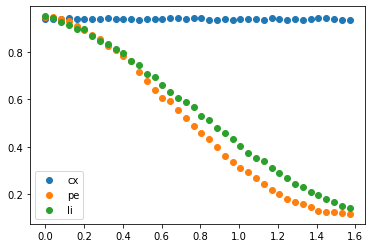

In [7]:
import matplotlib.pyplot as plt

plt.scatter(phi_values, process_fidelities['cx'], label='cx')
plt.scatter(phi_values, process_fidelities['pe'], label='pe')
plt.scatter(phi_values, process_fidelities['li'], label='li')
plt.legend()

In [ ]:
from qiskit import transpile
circuit = QuantumCircuit(2)
circuit.rzz(np.pi / 4., 0, 1)
transpile(circuit, basis_gates=['x', 'sx', 'cx', 'rz', 'id']).draw('mpl')

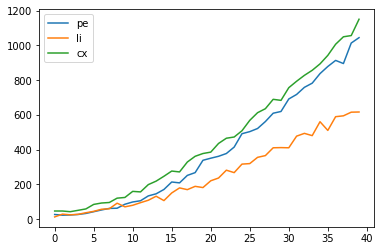

In [14]:
plt.plot(source['pe']['(("Zp", "Xp"), ("Z", "X"))'][:, 2], label='pe')
plt.plot(source['li']['(("Zp", "Xp"), ("Z", "X"))'][:, 2], label='li')
plt.plot(source['cx']['(("Zp", "Xp"), ("Z", "X"))'][:, 2], label='cx')
plt.legend()